<a href="https://colab.research.google.com/github/songmac/2023-Sesac-Lecture-and-Project/blob/master/231017%20%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D%20%ED%86%A0%ED%94%BD%EB%AA%A8%EB%8D%B8%EB%A7%81_LSA%2C%20LDA_%EC%8B%A4%EC%8A%B5(understanding).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실습 1 - 간단한 토픽모델링 구현 LSA
(토픽 모델링 : n개 토픽으로 모델링)

구현 순서
- 문서집합을 TDM으로 표현
- Truncated SVD 분해 (단어빈도-> 벡터화 및 특이값으로 분해)
- 벡터를 활용하여 단어 또는 문서간 유사도 계산


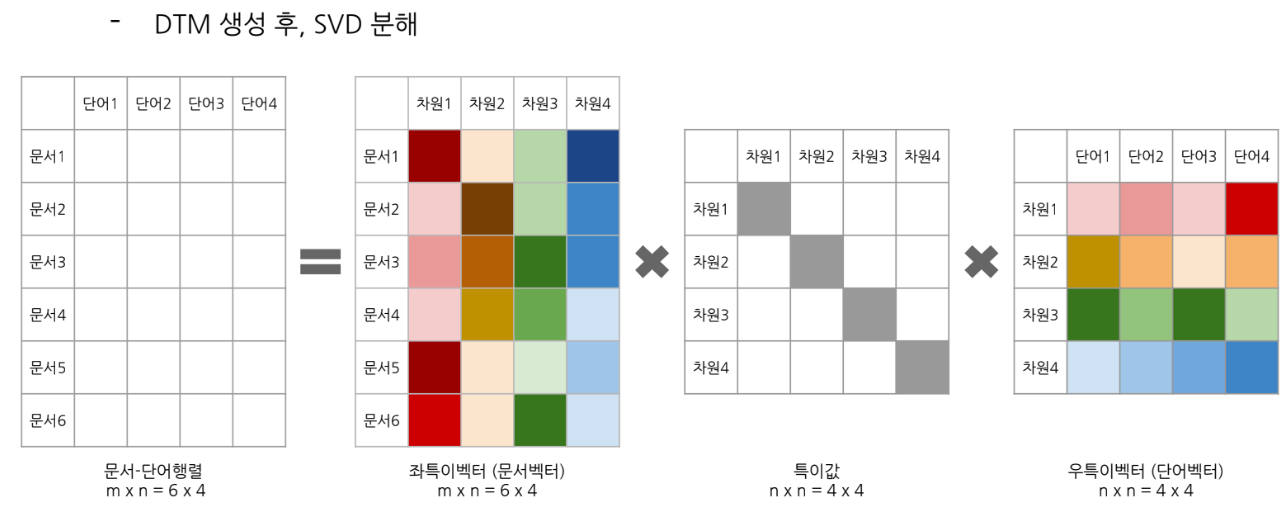

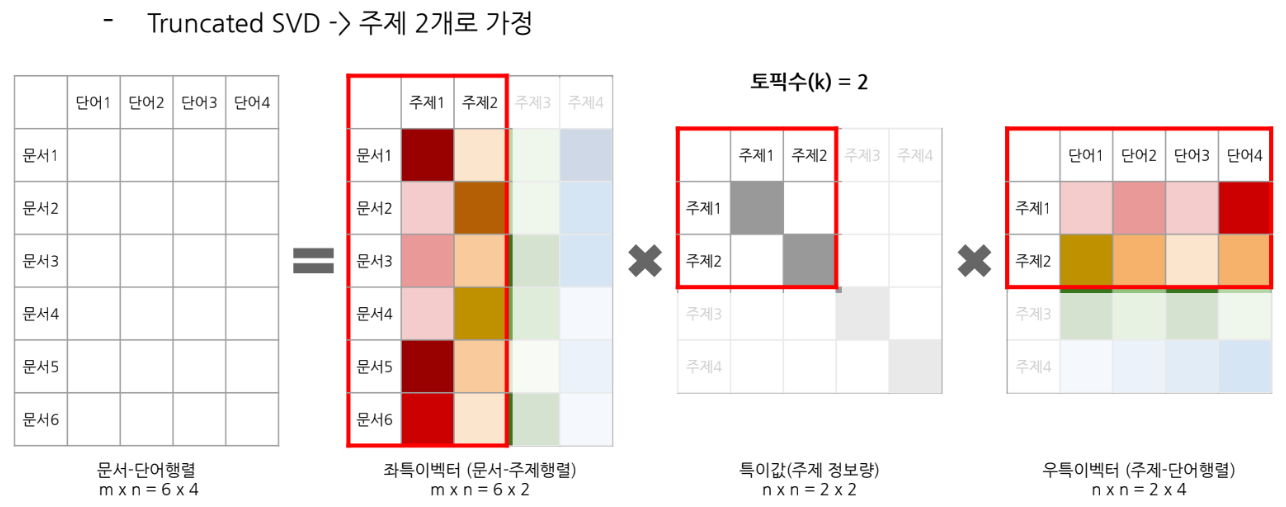

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

docs = ['바나나 사과 포도 포도', #문서set : numpy sparse matrix (10,12)
         '사과 포도',
         '포도 바나나',
         '짜장면 짬뽕 탕수육',
         '볶음밥 탕수육',
         '짜장면 짬뽕',
         '된장찌개 김치찌개 김치 비빔밥',
         '김치 된장 비빔밥',
         '비빔밥 김치',
         '사과 볶음밥 김치 된장']

n_topic=3
#선언
tfidf_vect = TfidfVectorizer() #문서set에서 단어와 문서의 관련성(상대적 중요도)를 벡터화
tfidf = tfidf_vect.fit_transform(docs) #학습
tfidf

<10x12 sparse matrix of type '<class 'numpy.float64'>'
	with 27 stored elements in Compressed Sparse Row format>

In [ ]:
svd = TruncatedSVD(n_components=n_topic) #토픽 수 만큼 행렬 분할 #차원축소
u_sigma = svd.fit_transform(tfidf) #압축 데이터 재학습
svd.components_ #계산된 토픽 별 단어 벡터

array([[ 0.39094311,  0.08663945,  0.2634605 ,  0.08663945,  0.31533599,
         0.1677167 ,  0.33012626,  0.42118555,  0.01907605,  0.01907605,
         0.05422822,  0.58747296],
       [ 0.49683512,  0.13720069,  0.26962551,  0.13720069, -0.29774469,
         0.10773075,  0.49275818, -0.18567019,  0.02131272,  0.02131272,
         0.04450862, -0.51222803],
       [-0.06285924, -0.02901254, -0.00762375, -0.02901254, -0.01957621,
         0.19210545, -0.09004258,  0.00851823,  0.60658392,  0.60658392,
         0.46061907, -0.02794911]])

In [ ]:
u_sigma #계산된 토픽 별 문장 벡터

array([[ 0.77911352, -0.61739759, -0.02777711],
       [ 0.71322927, -0.49348856, -0.0137397 ],
       [ 0.62415247, -0.56136755, -0.03313667],
       [ 0.0533358 ,  0.05030687,  0.96636132],
       [ 0.15693875,  0.10764949,  0.46154593],
       [ 0.02697761,  0.03014073,  0.85783921],
       [ 0.391673  ,  0.5605861 , -0.0963165 ],
       [ 0.55622043,  0.7061369 , -0.08787492],
       [ 0.50647534,  0.69837583, -0.10905876],
       [ 0.60121321,  0.32756638,  0.07791385]])

In [ ]:
vocab = tfidf_vect.get_feature_names_out() #단어 이름 출력
n=3

for idx, topic in enumerate(svd.components_):
  print("Topic %d:" % (idx), end='')
  print([(vocab[i], topic[i].round(5)) for i in topic.argsort()[:-n -1:-1]]) #round: 소수점 자리 수  #무엇을 의미? 토픽별 가장 연관성이 높은 단어 벡터 3개 출력

Topic 0:[('포도', 0.58747), ('사과', 0.42119), ('김치', 0.39094)]
Topic 1:[('김치', 0.49684), ('비빔밥', 0.49276), ('된장', 0.26963)]
Topic 2:[('짬뽕', 0.60658), ('짜장면', 0.60658), ('탕수육', 0.46062)]


# 단어벡터간의 상관관계

In [ ]:
#단어벡터
for i in range(len(vocab)): #vocab = 12
  print("{} : {}".format(vocab[i], svd.components_.T[i]))

김치 : [ 0.39094311  0.49683512 -0.06285924]
김치찌개 : [ 0.08663945  0.13720069 -0.02901254]
된장 : [ 0.2634605   0.26962551 -0.00762375]
된장찌개 : [ 0.08663945  0.13720069 -0.02901254]
바나나 : [ 0.31533599 -0.29774469 -0.01957621]
볶음밥 : [0.1677167  0.10773075 0.19210545]
비빔밥 : [ 0.33012626  0.49275818 -0.09004258]
사과 : [ 0.42118555 -0.18567019  0.00851823]
짜장면 : [0.01907605 0.02131272 0.60658392]
짬뽕 : [0.01907605 0.02131272 0.60658392]
탕수육 : [0.05422822 0.04450862 0.46061907]
포도 : [ 0.58747296 -0.51222803 -0.02794911]


In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
# 코사인유사도
def cosine_similarity(a,b):
  return dot(a,b)/(norm(a)*norm(b))
#코사인 유사도를 사용해서 행렬의 유사도 구하기
def calc_similarity_matrix(vectors):
  n_word = len(vectors)
  similarity_matrix = np.zeros((n_word, n_word))

  for i in range(n_word):
    #위에서 정의한 코사인 유사도 사용
    for j in range(i,n_word):
      similarity_matrix[j,i] = cosine_similarity(vectors[i], vectors[j]).round(4)
  return similarity_matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_similarity(similarity_matrix):
  uniform_data = similarity_matrix
  mask = np.triu(np.ones_like(similarity_matrix, dtype=np.bool))
  plt.rcParams['figure.figsize'] = [8,6]
  ax = sns.heatmap(uniform_data, mask = mask,
                   annot=True, fmt=".2f", annot_kws={'size':8},
                   cmap='coolwarm')
print(vocab)

['김치' '김치찌개' '된장' '된장찌개' '바나나' '볶음밥' '비빔밥' '사과' '짜장면' '짬뽕' '탕수육' '포도']


<ipython-input-103-a81a30275da7>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(similarity_matrix, dtype=np.bool))


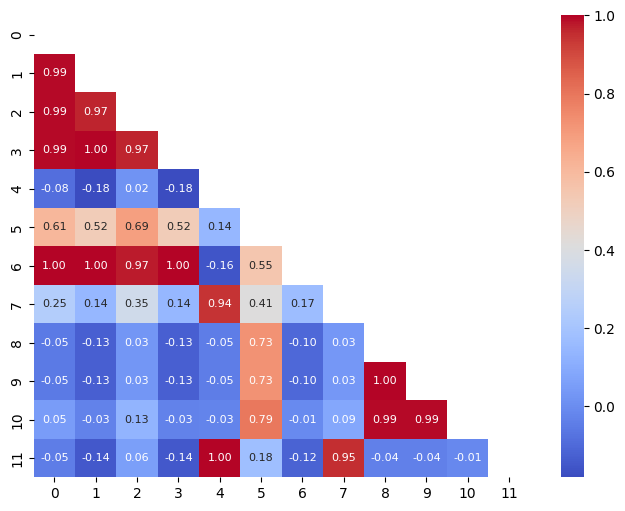

In [ ]:
word_vectors = svd.components_.T
word_similarity_matrix = calc_similarity_matrix(word_vectors)
visualize_similarity(word_similarity_matrix)

# 단어벡터 시각화

In [ ]:
# 한글 폰트 설정
# 설치하고 한글 적용이 안된다면, 런타임 > 런타임 다시시작 ; 하고 설치코드 제외하고 나머지 코드 실행

!sudo apt-get install -y fonts-nanum
!sudo fc-cache - fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
%matplotlib inline
import matplotlib.font_manager as fm
import matplotlib
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)

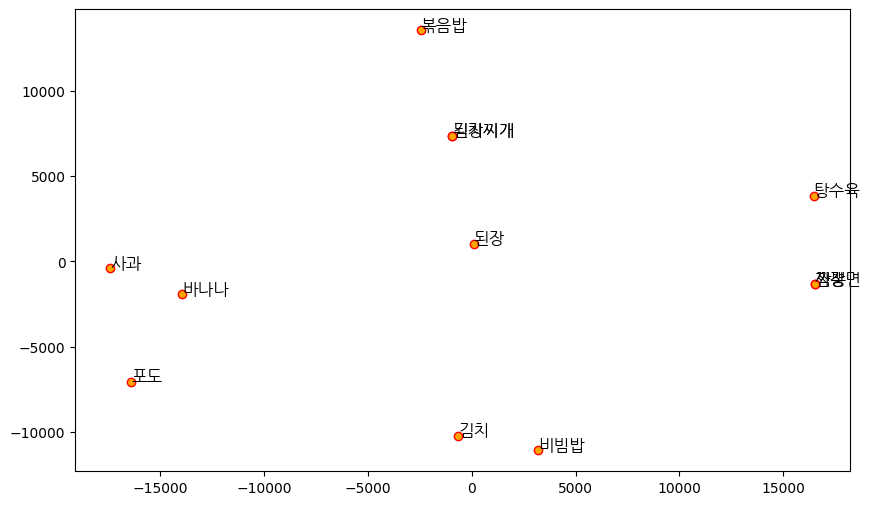

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
vectors = word_vectors
labels = tfidf_vect.get_feature_names_out()

def visualize_vectors(vectors, labels):
  tsne = TSNE(n_components=2, random_state=0, n_iter=10000, \
              perplexity=2)
  np.set_printoptions(suppress=True)
  T = tsne.fit_transform(vectors)

  plt.figure(figsize=(10,6))
  plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
  for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), \
                 textcoords='offset points', \
                 fontproperties=fontprop)

visualize_vectors(vectors, labels)

# 실습 2 - 간단한 토픽모델링 구현 LDA

In [ ]:
docs = ['바나나 사과 포도 포도',
         '사과 포도',
         '포도 바나나',
         '짜장면 짬뽕 탕수육',
         '볶음밥 탕수육',
         '짜장면 짬뽕',
         '된장찌개 김치찌개 김치 비빔밥',
         '김치 된장 비빔밥',
         '비빔밥 김치',
         '사과 볶음밥 김치 된장']

In [ ]:
from gensim import corpora
from gensim.models import LdaModel, TfidfModel

#분석할 문서를 공백으로 토큰화
tokenized_docs = []
for doc in docs:
  tokenized_docs.append(doc.split(' '))
  print(tokenized_docs)

[['바나나', '사과', '포도', '포도']]
[['바나나', '사과', '포도', '포도'], ['사과', '포도']]
[['바나나', '사과', '포도', '포도'], ['사과', '포도'], ['포도', '바나나']]
[['바나나', '사과', '포도', '포도'], ['사과', '포도'], ['포도', '바나나'], ['짜장면', '짬뽕', '탕수육']]
[['바나나', '사과', '포도', '포도'], ['사과', '포도'], ['포도', '바나나'], ['짜장면', '짬뽕', '탕수육'], ['볶음밥', '탕수육']]
[['바나나', '사과', '포도', '포도'], ['사과', '포도'], ['포도', '바나나'], ['짜장면', '짬뽕', '탕수육'], ['볶음밥', '탕수육'], ['짜장면', '짬뽕']]
[['바나나', '사과', '포도', '포도'], ['사과', '포도'], ['포도', '바나나'], ['짜장면', '짬뽕', '탕수육'], ['볶음밥', '탕수육'], ['짜장면', '짬뽕'], ['된장찌개', '김치찌개', '김치', '비빔밥']]
[['바나나', '사과', '포도', '포도'], ['사과', '포도'], ['포도', '바나나'], ['짜장면', '짬뽕', '탕수육'], ['볶음밥', '탕수육'], ['짜장면', '짬뽕'], ['된장찌개', '김치찌개', '김치', '비빔밥'], ['김치', '된장', '비빔밥']]
[['바나나', '사과', '포도', '포도'], ['사과', '포도'], ['포도', '바나나'], ['짜장면', '짬뽕', '탕수육'], ['볶음밥', '탕수육'], ['짜장면', '짬뽕'], ['된장찌개', '김치찌개', '김치', '비빔밥'], ['김치', '된장', '비빔밥'], ['비빔밥', '김치']]
[['바나나', '사과', '포도', '포도'], ['사과', '포도'], ['포도', '바나나'], ['짜장면', '짬뽕', '탕수육'], ['볶음밥', '탕수육'], ['짜장면', '짬뽕'],

In [ ]:
id2word = corpora.Dictionary(tokenized_docs)
print(id2word)

Dictionary<12 unique tokens: ['바나나', '사과', '포도', '짜장면', '짬뽕']...>


In [ ]:
for value in id2word:
  print(value, id2word[value])

0 바나나
1 사과
2 포도
3 짜장면
4 짬뽕
5 탕수육
6 볶음밥
7 김치
8 김치찌개
9 된장찌개
10 비빔밥
11 된장


In [ ]:
corpus_TDM = []
for doc in tokenized_docs:
  print(doc)
  result = id2word.doc2bow(doc)
  print(result)
  corpus_TDM.append(result)
  print(corpus_TDM)

['바나나', '사과', '포도', '포도']
[(0, 1), (1, 1), (2, 2)]
[[(0, 1), (1, 1), (2, 2)]]
['사과', '포도']
[(1, 1), (2, 1)]
[[(0, 1), (1, 1), (2, 2)], [(1, 1), (2, 1)]]
['포도', '바나나']
[(0, 1), (2, 1)]
[[(0, 1), (1, 1), (2, 2)], [(1, 1), (2, 1)], [(0, 1), (2, 1)]]
['짜장면', '짬뽕', '탕수육']
[(3, 1), (4, 1), (5, 1)]
[[(0, 1), (1, 1), (2, 2)], [(1, 1), (2, 1)], [(0, 1), (2, 1)], [(3, 1), (4, 1), (5, 1)]]
['볶음밥', '탕수육']
[(5, 1), (6, 1)]
[[(0, 1), (1, 1), (2, 2)], [(1, 1), (2, 1)], [(0, 1), (2, 1)], [(3, 1), (4, 1), (5, 1)], [(5, 1), (6, 1)]]
['짜장면', '짬뽕']
[(3, 1), (4, 1)]
[[(0, 1), (1, 1), (2, 2)], [(1, 1), (2, 1)], [(0, 1), (2, 1)], [(3, 1), (4, 1), (5, 1)], [(5, 1), (6, 1)], [(3, 1), (4, 1)]]
['된장찌개', '김치찌개', '김치', '비빔밥']
[(7, 1), (8, 1), (9, 1), (10, 1)]
[[(0, 1), (1, 1), (2, 2)], [(1, 1), (2, 1)], [(0, 1), (2, 1)], [(3, 1), (4, 1), (5, 1)], [(5, 1), (6, 1)], [(3, 1), (4, 1)], [(7, 1), (8, 1), (9, 1), (10, 1)]]
['김치', '된장', '비빔밥']
[(7, 1), (10, 1), (11, 1)]
[[(0, 1), (1, 1), (2, 2)], [(1, 1), (2, 1)], [(0, 1)

In [ ]:
tfidf = TfidfModel(corpus_TDM)
corpus_TFIDF = tfidf[corpus_TDM]

n =3 #토픽갯수 - 변경 가능
lda = LdaModel(corpus=corpus_TFIDF,
              id2word=id2word,
               num_topics=n,
               random_state=100)

for t in lda.print_topics():
  print(t[0], " : ", t[1])


0  :  0.158*"탕수육" + 0.105*"볶음밥" + 0.100*"된장찌개" + 0.100*"짬뽕" + 0.099*"김치찌개" + 0.097*"짜장면" + 0.078*"비빔밥" + 0.071*"김치" + 0.056*"포도" + 0.049*"사과"
1  :  0.241*"포도" + 0.170*"바나나" + 0.158*"사과" + 0.053*"김치" + 0.051*"볶음밥" + 0.050*"된장" + 0.049*"짬뽕" + 0.048*"비빔밥" + 0.048*"짜장면" + 0.048*"탕수육"
2  :  0.154*"비빔밥" + 0.150*"김치" + 0.148*"된장" + 0.097*"짜장면" + 0.094*"짬뽕" + 0.089*"볶음밥" + 0.068*"사과" + 0.043*"포도" + 0.042*"바나나" + 0.042*"탕수육"
